In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

data = pd.read_csv('preprocessed_data.csv')

# Feature Extraction

In [8]:
# Average the numerical features

numerical_weather_features = [
    'temp', 'humidity', 'wind_speed', 'pressure', 'clouds_all',
    'rain_1h', 'rain_3h', 'snow_3h', 'visibility', 'wind_deg'
]

# Identify temperature-related columns (specific to weather data)
temp_columns = [col for col in data.columns if 'temp_' in col]
max_temp_columns = [col for col in temp_columns if 'temp_max' in col]
min_temp_columns = [col for col in temp_columns if 'temp_min' in col]
avg_temp_columns = [col for col in temp_columns if col not in max_temp_columns and col not in min_temp_columns]

# Compute the average for 'temp', the max for 'temp_max', and the min for 'temp_min'
data['avg_temp'] = data[avg_temp_columns].mean(axis=1)
data['max_temp'] = data[max_temp_columns].max(axis=1)
data['min_temp'] = data[min_temp_columns].min(axis=1)

# Identify columns related to energy generation, forecasts, and prices
generation_columns = [col for col in data.columns if 'generation' in col or 'forecast' in col or 'price' in col]

# Average numerical weather features across cities
for feature in numerical_weather_features:
    # Identify all city-specific columns for this feature
    city_specific_columns = [col for col in data.columns if col.startswith(feature + '_')]
    
    # Compute the average across cities
    if city_specific_columns:
        data[f'avg_{feature}'] = data[city_specific_columns].mean(axis=1)
        
        # Drop the original city-specific weather columns
        data.drop(columns=city_specific_columns, inplace=True)

# Drop the original temperature columns (excluding generation columns)
columns_to_drop = [col for col in (avg_temp_columns + max_temp_columns + min_temp_columns) if col in data.columns and col not in generation_columns]
data.drop(columns=columns_to_drop, inplace=True)

# Reorder the DataFrame: Place 'dt_iso', followed by averaged features, then the rest
averaged_columns = [col for col in data.columns if col.startswith('avg_') or col in ['avg_temp', 'max_temp', 'min_temp']]
columns_order = ['dt_iso'] + averaged_columns + [col for col in data.columns if col not in averaged_columns and col != 'dt_iso']
data = data[columns_order]



In [9]:
# Extract time-based features from 'dt_iso'

# Convert 'dt_iso' to datetime type with UTC handling
data['dt_iso'] = pd.to_datetime(data['dt_iso'], utc=True, errors='coerce')

# Extract time-based features
data['hour_of_day'] = data['dt_iso'].dt.hour
data['day_of_week'] = data['dt_iso'].dt.dayofweek
data['month'] = data['dt_iso'].dt.month

# Create lag features for 'total load actual'

# 1-hour lag
data['total_load_actual_lag_1'] = data['total load actual'].shift(1)

# 12-hour lag
data['total_load_actual_lag_12'] = data['total load actual'].shift(12)

# 24-hour lag
data['total_load_actual_lag_24'] = data['total load actual'].shift(24)

# Drop the rows with NaN values due to lag creation
data.dropna(inplace=True)

# Display the first few rows of the reordered DataFrame
data.head()


,dt_iso,avg_temp,max_temp,min_temp,avg_humidity,avg_wind_speed,avg_pressure,avg_clouds_all,avg_rain_1h,avg_rain_3h,avg_snow_3h,avg_wind_deg,weather_description_broken clouds_ Barcelona,weather_description_broken clouds_Bilbao,weather_description_broken clouds_Madrid,weather_description_broken clouds_Seville,weather_description_broken clouds_Valencia,weather_description_drizzle_ Barcelona,weather_description_drizzle_Bilbao,weather_description_drizzle_Madrid,weather_description_drizzle_Seville,weather_description_drizzle_Valencia,weather_description_dust_ Barcelona,weather_description_dust_Bilbao,weather_description_dust_Madrid,weather_description_dust_Seville,weather_description_dust_Valencia,weather_description_few clouds_ Barcelona,weather_description_few clouds_Bilbao,weather_description_few clouds_Madrid,weather_description_few clouds_Seville,weather_description_few clouds_Valencia,weather_description_fog_ Barcelona,weather_description_fog_Bilbao,weather_description_fog_Madrid,weather_description_fog_Seville,weather_description_fog_Valencia,weather_description_haze_ Barcelona,weather_description_haze_Bilbao,weather_description_haze_Madrid,weather_description_haze_Seville,weather_description_haze_Valencia,weather_description_heavy intensity drizzle_ Barcelona,weather_description_heavy intensity drizzle_Bilbao,weather_description_heavy intensity drizzle_Madrid,weather_description_heavy intensity drizzle_Seville,weather_description_heavy intensity drizzle_Valencia,weather_description_heavy intensity rain_ Barcelona,weather_description_heavy intensity rain_Bilbao,weather_description_heavy intensity rain_Madrid,weather_description_heavy intensity rain_Seville,weather_description_heavy intensity rain_Valencia,weather_description_heavy intensity shower rain_ Barcelona,weather_description_heavy intensity shower rain_Bilbao,weather_description_heavy intensity shower rain_Madrid,weather_description_heavy intensity shower rain_Seville,weather_description_heavy intensity shower rain_Valencia,weather_description_heavy snow_ Barcelona,weather_description_heavy snow_Bilbao,weather_description_heavy snow_Madrid,weather_description_heavy snow_Seville,weather_description_heavy snow_Valencia,weather_description_light intensity drizzle_ Barcelona,weather_description_light intensity drizzle_Bilbao,weather_description_light intensity drizzle_Madrid,weather_description_light intensity drizzle_Seville,weather_description_light intensity drizzle_Valencia,weather_description_light intensity drizzle rain_ Barcelona,weather_description_light intensity drizzle rain_Bilbao,weather_description_light intensity drizzle rain_Madrid,weather_description_light intensity drizzle rain_Seville,weather_description_light intensity drizzle rain_Valencia,weather_description_light intensity shower rain_ Barcelona,weather_description_light intensity shower rain_Bilbao,weather_description_light intensity shower rain_Madrid,weather_description_light intensity shower rain_Seville,weather_description_light intensity shower rain_Valencia,weather_description_light rain_ Barcelona,weather_description_light rain_Bilbao,weather_description_light rain_Madrid,weather_description_light rain_Seville,weather_description_light rain_Valencia,weather_description_light rain and snow_ Barcelona,weather_description_light rain and snow_Bilbao,weather_description_light rain and snow_Madrid,weather_description_light rain and snow_Seville,weather_description_light rain and snow_Valencia,weather_description_light shower sleet_ Barcelona,weather_description_light shower sleet_Bilbao,weather_description_light shower sleet_Madrid,weather_description_light shower sleet_Seville,weather_description_light shower sleet_Valencia,weather_description_light shower snow_ Barcelona,weather_description_light shower snow_Bilbao,weather_description_light shower snow_Madrid,weather_description_light shower snow_Seville,weather_description_light shower snow_Valencia,weather_description_light snow_ Barcelona,weat

In [10]:
# Apply sin/cos transformations for cyclic features
data['hour_sin'] = np.sin(2 * np.pi * data['hour_of_day'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour_of_day'] / 24)

data['day_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Drop the original columns
data.drop(columns=['hour_of_day', 'day_of_week', 'month'], inplace=True)

# Order Columns

time_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']
averaged_features = [col for col in data.columns if col.startswith('avg_')]
lag_features = [col for col in data.columns if 'lag' in col]
other_columns = [col for col in data.columns if col not in ['dt_iso'] + time_features + averaged_features + lag_features]

ordered_columns = ['dt_iso'] + time_features + averaged_features + other_columns + lag_features

# Reorder the DataFrame
data = data[ordered_columns]

# Display the first few rows of the reordered DataFrame
data.head()

,dt_iso,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,avg_temp,avg_humidity,avg_wind_speed,avg_pressure,avg_clouds_all,avg_rain_1h,avg_rain_3h,avg_snow_3h,avg_wind_deg,max_temp,min_temp,weather_description_broken clouds_ Barcelona,weather_description_broken clouds_Bilbao,weather_description_broken clouds_Madrid,weather_description_broken clouds_Seville,weather_description_broken clouds_Valencia,weather_description_drizzle_ Barcelona,weather_description_drizzle_Bilbao,weather_description_drizzle_Madrid,weather_description_drizzle_Seville,weather_description_drizzle_Valencia,weather_description_dust_ Barcelona,weather_description_dust_Bilbao,weather_description_dust_Madrid,weather_description_dust_Seville,weather_description_dust_Valencia,weather_description_few clouds_ Barcelona,weather_description_few clouds_Bilbao,weather_description_few clouds_Madrid,weather_description_few clouds_Seville,weather_description_few clouds_Valencia,weather_description_fog_ Barcelona,weather_description_fog_Bilbao,weather_description_fog_Madrid,weather_description_fog_Seville,weather_description_fog_Valencia,weather_description_haze_ Barcelona,weather_description_haze_Bilbao,weather_description_haze_Madrid,weather_description_haze_Seville,weather_description_haze_Valencia,weather_description_heavy intensity drizzle_ Barcelona,weather_description_heavy intensity drizzle_Bilbao,weather_description_heavy intensity drizzle_Madrid,weather_description_heavy intensity drizzle_Seville,weather_description_heavy intensity drizzle_Valencia,weather_description_heavy intensity rain_ Barcelona,weather_description_heavy intensity rain_Bilbao,weather_description_heavy intensity rain_Madrid,weather_description_heavy intensity rain_Seville,weather_description_heavy intensity rain_Valencia,weather_description_heavy intensity shower rain_ Barcelona,weather_description_heavy intensity shower rain_Bilbao,weather_description_heavy intensity shower rain_Madrid,weather_description_heavy intensity shower rain_Seville,weather_description_heavy intensity shower rain_Valencia,weather_description_heavy snow_ Barcelona,weather_description_heavy snow_Bilbao,weather_description_heavy snow_Madrid,weather_description_heavy snow_Seville,weather_description_heavy snow_Valencia,weather_description_light intensity drizzle_ Barcelona,weather_description_light intensity drizzle_Bilbao,weather_description_light intensity drizzle_Madrid,weather_description_light intensity drizzle_Seville,weather_description_light intensity drizzle_Valencia,weather_description_light intensity drizzle rain_ Barcelona,weather_description_light intensity drizzle rain_Bilbao,weather_description_light intensity drizzle rain_Madrid,weather_description_light intensity drizzle rain_Seville,weather_description_light intensity drizzle rain_Valencia,weather_description_light intensity shower rain_ Barcelona,weather_description_light intensity shower rain_Bilbao,weather_description_light intensity shower rain_Madrid,weather_description_light intensity shower rain_Seville,weather_description_light intensity shower rain_Valencia,weather_description_light rain_ Barcelona,weather_description_light rain_Bilbao,weather_description_light rain_Madrid,weather_description_light rain_Seville,weather_description_light rain_Valencia,weather_description_light rain and snow_ Barcelona,weather_description_light rain and snow_Bilbao,weather_description_light rain and snow_Madrid,weather_description_light rain and snow_Seville,weather_description_light rain and snow_Valencia,weather_description_light shower sleet_ Barcelona,weather_description_light shower sleet_Bilbao,weather_description_light shower sleet_Madrid,weather_description_light shower sleet_Seville,weather_description_light shower sleet_Valencia,weather_description_light shower snow_ Barcelona,weather_description_light shower snow_Bilbao,weather_description_light shower snow_Madrid,weather_description_light shower snow_Seville,weather_description_light shower snow_V

# Feature Selection

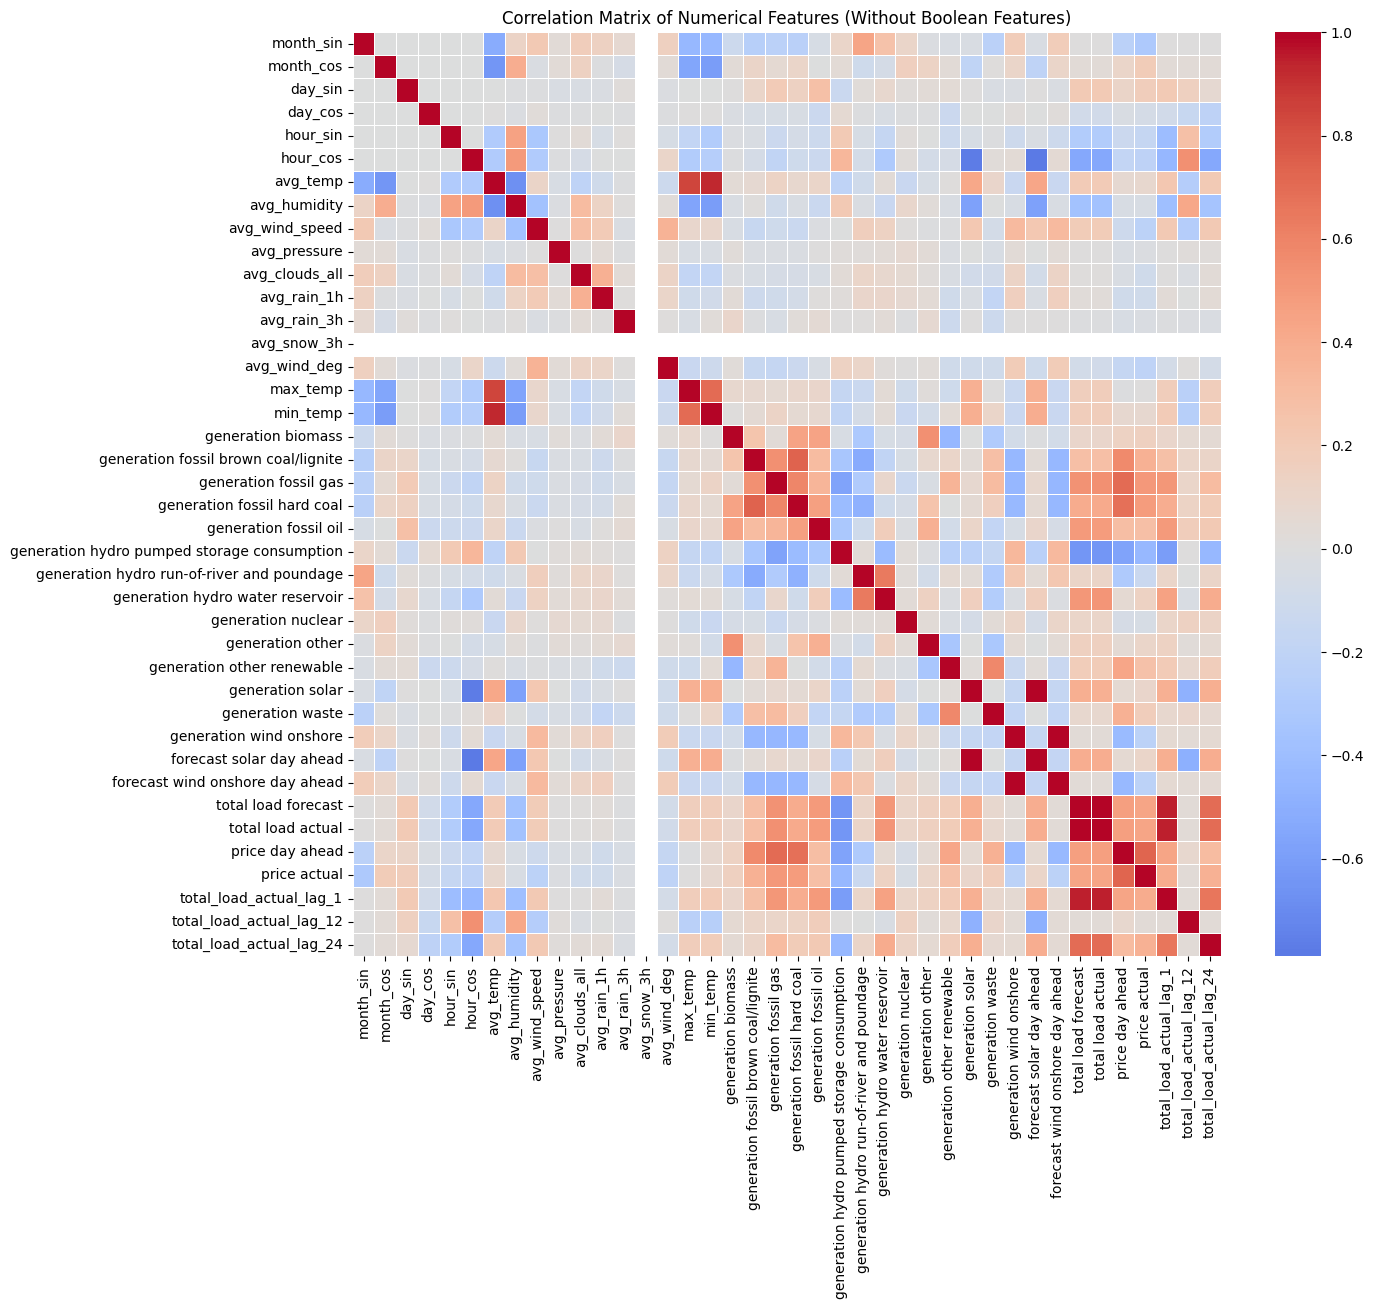

Highly correlated feature pairs (threshold > 0.9): [('avg_temp', 'min_temp'), ('min_temp', 'avg_temp'), ('generation solar', 'forecast solar day ahead'), ('generation wind onshore', 'forecast wind onshore day ahead'), ('forecast solar day ahead', 'generation solar'), ('forecast wind onshore day ahead', 'generation wind onshore'), ('total load forecast', 'total load actual'), ('total load forecast', 'total_load_actual_lag_1'), ('total load actual', 'total load forecast'), ('total load actual', 'total_load_actual_lag_1'), ('total_load_actual_lag_1', 'total load forecast'), ('total_load_actual_lag_1', 'total load actual')]


In [11]:
# Drop all boolean features (e.g., weather descriptions, icons)
boolean_columns = [col for col in data.columns if 'weather_description_' in col or 'weather_icon_' in col or 'weather_main_' in col or 'weather_id_' in col]
data = data.drop(columns=boolean_columns)

# Compute the correlation matrix for numerical features
numerical_data = data.select_dtypes(include='number')
correlation_matrix = numerical_data.corr()

# Set a high correlation threshold (absolute correlation > 0.9)
high_corr_threshold = 0.9

# Identify pairs of features with high correlation
high_corr_pairs = [
    (col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > high_corr_threshold
]

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features (Without Boolean Features)")
plt.show()

# Print the list of highly correlated feature pairs
print("Highly correlated feature pairs (threshold > 0.9):", high_corr_pairs)

In [12]:
# Drop highly correlated features

data = data.drop(columns=['min_temp', 'generation solar', 'generation wind onshore', 'total load forecast'])

data.to_csv('final_features_data.csv', index=False)

In [13]:
# Data splitting

X = data.drop(columns=['total load actual', 'dt_iso'])  # Exclude the target and timestamp
y = data['total load actual']

# Perform the time-based split, setting shuffle=False to maintain order
# Split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)

# Now split the temp into validation and test sets (50% each of the remaining 30%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Shape of the splits
print("Training set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Validation set shape (X_val, y_val):", X_val.shape, y_val.shape)
print("Testing set shape (X_test, y_test):", X_test.shape, y_test.shape)

# Save splits
X_train.to_csv('train/X_train.csv', index=False)
y_train.to_csv('train/y_train.csv', index=False)

X_val.to_csv('validation/X_val.csv', index=False)
y_val.to_csv('validation/y_val.csv', index=False)

X_test.to_csv('test/X_test.csv', index=False)
y_test.to_csv('test/y_test.csv', index=False)


Training set shape (X_train, y_train): (24528, 35) (24528,)
Validation set shape (X_val, y_val): (5256, 35) (5256,)
Testing set shape (X_test, y_test): (5256, 35) (5256,)
